In [ ]:
!pip install --upgrade diffusers transformers scipy
!pip install accelerate
!pip install pillow
!pip install sentence_transformers

In [ ]:
!huggingface-cli login

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import torch
from torch import autocast
from diffusers import StableDiffusionPipeline
import tensorflow as tf
from PIL import Image
import numpy as np

model_id = "CompVis/stable-diffusion-v1-4"
device = "cuda"

In [ ]:
pipe = StableDiffusionPipeline.from_pretrained(model_id, use_auth_token=True)
pipe = pipe.to(device)

In [ ]:
VGG16 = tf.keras.applications.VGG16(include_top=True, weights='imagenet')
x = VGG16.layers[-2].output
VGG16_MODEL = tf.keras.Model(inputs = VGG16.input, outputs = x)
VGG16_MODEL.trainable = False
VGG16_MODEL.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [ ]:
# generate image from stable-diffusion
def get_image_stable_diffusion(prompt):
  with autocast("cuda"):
    image = pipe(prompt, guidance_scale=7.5) 
    
  # image.save("image.png")
  # print(image)
  img = image.images[0]
  return img, image

In [ ]:
from tensorflow.keras.utils import img_to_array
# generate two images to compare
def get_images(prompt1, prompt2):
  # size = 224, 224
  img1, image1 = get_image_stable_diffusion(prompt1)
  img2, image2 = get_image_stable_diffusion(prompt2)
  return img1, img2, image1, image2

In [ ]:
from tqdm import tqdm
import datetime
def save_images(filename, dir):
  images_list = []
  with open(filename) as f:
    lines = [line.rstrip('\n').split(':') for line in f]
  print(lines)
  for line in tqdm(lines):
    if len(line) == 1:
      line1 = line[0]
      line2 = line[0]  
    else:
      line1 = line[0]
      line2 = line[1]
    # img1, img2, image1, image2 = get_images(line1, line2)
    img1, image1 = get_image_stable_diffusion(line1)
    date = datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")
    name1 = dir + date + "-" + line1 + ".png"
    if image1.nsfw_content_detected[0] == True:
      continue
    img2, image2 = get_image_stable_diffusion(line2)
    date = datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")
    name2 = dir + date + "-" + line2 + ".png"
    if image2.nsfw_content_detected[0] == True:
      continue
    images_list += [img1, img2]
    img1.save(name1)
    img2.save(name2)
  return images_list

In [ ]:
same_images_list = save_images("/content/drive/MyDrive/523/text_ptompts_same.txt", "/content/drive/MyDrive/523/stable_diffusion_images/same/")

In [ ]:
len(same_images_list)

208

In [ ]:
mod_images_list = save_images("/content/drive/MyDrive/523/text_ptompts_modified.txt", "/content/drive/MyDrive/523/stable_diffusion_images/different/")

In [ ]:
len(mod_images_list)

210

## Images generated with same prompts

In [ ]:
same_img1, same_img2, _, _ = get_images("A painting of a baby riding a bike", "A painting of a baby riding a bike")

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

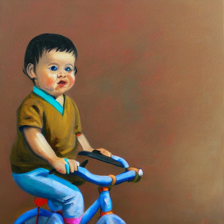

In [ ]:
same_img1

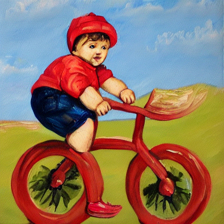

In [ ]:
same_img2

## Images generated with small modification to the prompts

In [ ]:
diff_img1, diff_img2, _, _ = get_images("A painting of a baby riding a bike", "Painting of a baby riding a bike")

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

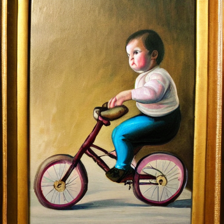

In [ ]:
diff_img1

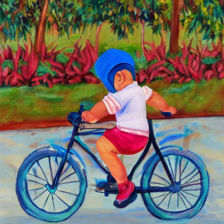

In [ ]:
diff_img2

# Images generated with different prompts

In [ ]:
comp_diff_img1, comp_diff_img2, _, _ = get_images("A painting of a baby riding a bike", "A pink horse on the sea")

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

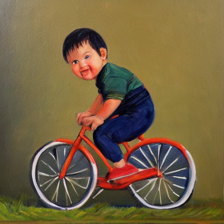

In [ ]:
comp_diff_img1

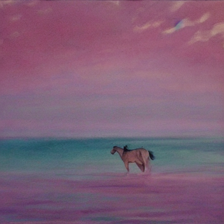

In [ ]:
comp_diff_img2

# Load the images

In [88]:
from PIL import Image
import glob
same_images_list = []
for filename in glob.glob("/content/drive/MyDrive/523/stable_diffusion_images/same/*.png"):
    im=Image.open(filename)
    same_images_list.append(im)

mod_images_list = []
for filename in glob.glob("/content/drive/MyDrive/523/stable_diffusion_images/modified/*.png"):
    im=Image.open(filename)
    mod_images_list.append(im)
  
import copy, random
diff_images_list = copy.deepcopy(mod_images_list)
random.shuffle(diff_images_list)

# Similarity metrics

## L2 Norm

In [ ]:
# Helper functions
def image_to_feature_vector(img):
    return np.array(tf.squeeze(VGG16_MODEL(tf.expand_dims(img, 0))))

from numpy.linalg import norm
def similarity(v1, v2):
    v1 /= norm(v1)
    v2 /= norm(v2)
    return 1. - norm(v2 - v1)

In [ ]:
def get_similarity(img1, img2):
  mean = np.array([0.485, 0.456, 0.406])
  std = np.array([0.229, 0.224, 0.225])

  image1 = tf.image.resize_with_pad(img1, 224, 224)
  # Normalize
  image1 = tf.math.divide(image1, 255.)
  image1 = tf.math.subtract(image1, mean)
  image1 = tf.math.divide(image1, std)
  image1 = image_to_feature_vector(image1)

  image2 = tf.image.resize_with_pad(img2, 224, 224)
  # Normalize
  image2 = tf.math.divide(image2, 255.)
  image2 = tf.math.subtract(image2, mean)
  image2 = tf.math.divide(image2, std)
  image2 = image_to_feature_vector(image2)

  sim = similarity(image1, image2)
  return sim

## Cosine similarity

In [ ]:
from scipy.spatial.distance import cosine
def get_cosine_sim(img1, img2):
  return 1 - cosine(img1, img2)

## Inception score

In [ ]:
# from tf.keras.applications.inception_v3 import InceptionV3
# from tf.keras.applications.inception_v3 import preprocess_input
from math import floor
from numpy import ones
from numpy import expand_dims
from numpy import log
from numpy import mean
from numpy import std
from numpy import exp
# load inception v3 model
inception_model = tf.keras.applications.inception_v3.InceptionV3()
def calculate_inception_score(images, eps=1E-16):
  images = np.array(images)
  processed = images.astype('float32')
  # pre-process raw images for inception v3 model
  processed = tf.keras.applications.inception_v3.preprocess_input(processed)
  # predict class probabilities for images
  yhat = inception_model.predict(processed)
  # enumerate splits of images/predictions
  p_yx = yhat
  # calculate p(y)
  p_y = expand_dims(p_yx.mean(axis=0), 0)
  # calculate KL divergence using log probabilities
  kl_d = p_yx * (log(p_yx + eps) - log(p_y + eps))
  # sum over classes
  sum_kl_d = kl_d.sum(axis=1)
  # average over images
  avg_kl_d = mean(sum_kl_d)
  # undo the log
  is_score = exp(avg_kl_d)
  return is_score

In [ ]:
def get_average_is(images):
  inception_scores = []
  for i in range(0, len(images), 2):
    img1 = copy.deepcopy(images[i])
    img2 = copy.deepcopy(images[i+1])
    size = 299, 299
    img1.thumbnail(size)
    img2.thumbnail(size)
    np_img1 = img_to_array(img1)
    np_img2 = img_to_array(img2)
    is_score = calculate_inception_score([np_img1, np_img2])
    inception_scores.append(is_score)
  return np.mean(np.array(inception_scores)), np.std(np.array(inception_scores))

In [ ]:
is_same_mean, is_same_std = get_average_is(same_images_list)

In [ ]:
print("Mean inception score for same prompt pairs:", is_same_mean)
print("Standard deviation of the inception scores for same prompt pairs:", is_same_std)

Mean inception score for same prompt pairs: 1.4703622
Standard deviation of the inception scores for same prompt pairs: 0.24865371


In [ ]:
is_mod_mean, is_mod_std = get_average_is(mod_images_list)

In [ ]:
print("Mean inception score for prompt pairs with small modifications:", is_mod_mean)
print("Standard deviation of the inception scores for prompt pairs with small modifications:", is_mod_std)

Mean inception score for prompt pairs with small modifications: 1.4360019
Standard deviation of the inception scores for prompt pairs with small modifications: 0.26435354


In [ ]:
is_diff_mean, is_diff_std = get_average_is(diff_images_list)

In [ ]:
print("Mean inception score for different prompt pairs:", is_diff_mean)
print("Standard deviation of the inception scores for different prompt pairs:", is_diff_std)

Mean inception score for different prompt pairs: 1.7355082
Standard deviation of the inception scores for different prompt pairs: 0.18611804


# VGG16 Feature vector

In [ ]:
import copy
def vgg16_similarity(images):
  l2_sim_scores = []
  cosine_sim_scores = []
  fad_scores = []
  for i in tqdm(range(0, len(images), 2)):
    img1 = copy.deepcopy(images[i])
    img2 = copy.deepcopy(images[i+1])
    size = 224, 224
    img1.thumbnail(size)
    img2.thumbnail(size)
    np_img1 = img_to_array(img1)
    np_img2 = img_to_array(img2)
    # L2 Norm
    l2_sim = get_similarity(np_img1, np_img2)
    # Cosine similarity
    cosine_sim = get_cosine_sim(image_to_feature_vector(np_img1), image_to_feature_vector(np_img2))
    l2_sim_scores.append(l2_sim)
    cosine_sim_scores.append(cosine_sim)

  return np.mean(np.array(l2_sim_scores)), np.std(np.array(l2_sim_scores)), np.mean(np.array(cosine_sim_scores)), np.std(np.array(cosine_sim_scores))

In [ ]:
vgg_l2_same_mean, vgg_l2_same_std, vgg_cosine_same_mean, vgg_cosine_same_std = vgg16_similarity(same_images_list)

100%|██████████| 104/104 [00:06<00:00, 16.11it/s]


In [ ]:
print("Mean L2 Norm similarity score for same prompt pairs:", vgg_l2_same_mean)
print("Standard deviation of the L2 Norm similarity scores for same prompt pairs:", vgg_l2_same_std)
print("Mean cosine similarity score for same prompt pairs:", vgg_cosine_same_mean)
print("Standard deviation of the cosine similarity scores for same prompt pairs:", vgg_cosine_same_std)

Mean L2 Norm similarity score for same prompt pairs: 0.6668710639843574
Standard deviation of the L2 Norm similarity scores for same prompt pairs: 0.07082120174782845
Mean cosine similarity score for same prompt pairs: 0.48582421529751557
Standard deviation of the cosine similarity scores for same prompt pairs: 0.13458044251991483


In [ ]:
vgg_l2_mod_mean, vgg_l2_mod_std, vgg_cosine_mod_mean, vgg_cosine_mod_std = vgg16_similarity(mod_images_list)

100%|██████████| 105/105 [00:06<00:00, 15.96it/s]


In [ ]:
print("Mean L2 Norm similarity score for prompt pairs with small modifications:", vgg_l2_mod_mean)
print("Standard deviation of the L2 Norm similarity scores for prompt pairs with small modifications:", vgg_l2_mod_std)
print("Mean cosine similarity score for prompt pairs with small modifications:", vgg_cosine_mod_mean)
print("Standard deviation of the cosine similarity scores for prompt pairs with small modifications:", vgg_cosine_mod_std)

Mean L2 Norm similarity score for prompt pairs with small modifications: 0.6667294507934933
Standard deviation of the L2 Norm similarity scores for prompt pairs with small modifications: 0.05982508817613569
Mean cosine similarity score for prompt pairs with small modifications: 0.4766729451361157
Standard deviation of the cosine similarity scores for prompt pairs with small modifications: 0.12144347222692692


In [ ]:
vgg_l2_diff_mean, vgg_l2_diff_std, vgg_cosine_diff_mean, vgg_cosine_diff_std = vgg16_similarity(diff_images_list)

100%|██████████| 105/105 [00:06<00:00, 15.80it/s]


In [ ]:
print("Mean L2 Norm similarity score for different prompt pairs:", vgg_l2_diff_mean)
print("Standard deviation of the L2 Norm similarity scores for different prompt pairss:", vgg_l2_diff_std)
print("Mean cosine similarity score for different prompt pairs:", vgg_cosine_diff_mean)
print("Standard deviation of the cosine similarity scores for different prompt pairs:", vgg_cosine_diff_std)

Mean L2 Norm similarity score for different prompt pairs: 0.5458044676553635
Standard deviation of the L2 Norm similarity scores for different prompt pairss: 0.07031302342598067
Mean cosine similarity score for different prompt pairs: 0.24823392359983354
Standard deviation of the cosine similarity scores for different prompt pairs: 0.08598387554363968


# Using CLIP Model's dense representations 

In [ ]:
from sentence_transformers import SentenceTransformer, util
from PIL import Image
import glob
import os

# Load the OpenAI CLIP Model
print('Loading CLIP Model...')
model = SentenceTransformer('clip-ViT-B-32')

Loading CLIP Model...


Downloading:   0%|          | 0.00/690 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/4.03k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/525k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/316 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/605M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/389 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/604 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/961k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.88k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/116 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/122 [00:00<?, ?B/s]

ftfy or spacy is not installed using BERT BasicTokenizer instead of ftfy.


In [ ]:
def get_clip_encoding(img1, img2):
  encoded_image = model.encode([img1, img2], batch_size=2, convert_to_tensor=True, show_progress_bar=True)
  return encoded_image

In [ ]:
import copy
def clip_similarity(images):
  l2_sim_scores = []
  cosine_sim_scores = []
  inception_scores = []
  fad_scores = []
  for i in tqdm(range(0, len(images), 2)):
    img1 = copy.deepcopy(images[i])
    img2 = copy.deepcopy(images[i+1])
    encoded_image = get_clip_encoding(img1, img2)
    l2_sim = similarity(encoded_image[0].cpu(), encoded_image[1].cpu())
    # Cosine similarity
    cosine_sim = get_cosine_sim(encoded_image[0].cpu(), encoded_image[1].cpu())
    l2_sim_scores.append(l2_sim)
    cosine_sim_scores.append(cosine_sim)

  return np.mean(np.array(l2_sim_scores)), np.std(np.array(l2_sim_scores)), np.mean(np.array(cosine_sim_scores)), np.std(np.array(cosine_sim_scores))

In [ ]:
clip_same_mean, clip_same_std, clip_cosine_same_mean, clip_cosine_same_std = clip_similarity(same_images_list)

In [ ]:
print("Mean L2 Norm similarity score for same prompt pairs:", clip_same_mean)
print("Standard deviation of the L2 Norm similarity scores for same prompt pairs:", clip_same_std)
print("Mean cosine similarity score for same prompt pairs:", clip_cosine_same_mean)
print("Standard deviation of the cosine similarity scores for same prompt pairs:", clip_cosine_same_std)

Mean L2 Norm similarity score for same prompt pairs: 0.387734818773774
Standard deviation of the L2 Norm similarity scores for same prompt pairs: 0.14105767479055664
Mean cosine similarity score for same prompt pairs: 0.8026170435433204
Standard deviation of the cosine similarity scores for same prompt pairs: 0.09104637715906443


In [ ]:
clip_mod_mean, clip_mod_std, clip_cosine_mod_mean, clip_cosine_mod_std = clip_similarity(mod_images_list)

In [ ]:
print("Mean L2 Norm similarity score for prompt pairs with small modifications:", clip_mod_mean)
print("Standard deviation of the L2 Norm similarity scores for prompt pairs with small modifications:", clip_mod_std)
print("Mean cosine similarity score for prompt pairs with small modifications:", clip_cosine_mod_mean)
print("Standard deviation of the cosine similarity scores for prompt pairs with small modifications:", clip_cosine_mod_std)

Mean L2 Norm similarity score for prompt pairs with small modifications: 0.3640376948174976
Standard deviation of the L2 Norm similarity scores for prompt pairs with small modifications: 0.1425775177276741
Mean cosine similarity score for prompt pairs with small modifications: 0.7876117819831485
Standard deviation of the cosine similarity scores for prompt pairs with small modifications: 0.09330339308740497


In [ ]:
clip_diff_mean, clip_diff_std, clip_cosine_diff_mean, clip_cosine_diff_std = clip_similarity(diff_images_list)

In [ ]:
print("Mean L2 Norm similarity score for different prompt pairs:", clip_diff_mean)
print("Standard deviation of the L2 Norm similarity scores for different prompt pairss:", clip_diff_std)
print("Mean cosine similarity score for different prompt pairs:", clip_cosine_diff_mean)
print("Standard deviation of the cosine similarity scores for different prompt pairs:", clip_cosine_diff_std)

Mean L2 Norm similarity score for different prompt pairs: 0.04438207263038272
Standard deviation of the L2 Norm similarity scores for different prompt pairss: 0.0876619909035357
Mean cosine similarity score for different prompt pairs: 0.5395548780759175
Standard deviation of the cosine similarity scores for different prompt pairs: 0.08170530265961225
